# Direct Fidelity Estimation with Qiskit Superstaq

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/apps/dfe/dfe_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/apps/dfe/dfe_qss.ipynb)

This notebook demonstrates how to run a estimate the fidelity between two quantum states prepared in different devices using Superstaq. The direct fidelity estimation protocol is integrated into Superstaq following [*Cross-Platform Verification of Intermediate Scale Quantum Devices*](https://arxiv.org/abs/1909.01282) and can be accessed using `qiskit-superstaq`.

## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit,

In [1]:
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    import qiskit_superstaq as qss

In [2]:
# Required imports
import numpy as np

# Optional imports
# import os  # Used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [3]:
# Get the qiskit superstaq provider for Superstaq backend
provider = qss.SuperstaqProvider()

## Randomized measurements background

The core idea behind this protocol is the use of random measurements to measure the overlap between two states $\rho_1$ and $\rho_2$, defined as $\mathrm{Tr}(\rho_1 \rho_2)$. To do this, we measure both states in the same randomized Clifford product bases of the form $C_1 \otimes \cdots \otimes C_N$ where each $C_i$ is a one qubit Clifford and we are comparing $N$-qubit (sub)systems. We then compare the distributions over all random measurements to get estimate the overlap between the two states.

Succintly, the protocol goes as follows:

1. Apply the same random unitary $U_j = C_1 \otimes \cdots \otimes C_N$ to both states.

2. Measure both states in the standard computational basis $\left(|0\rangle^{\otimes N}, |1\rangle^{\otimes N}\right)$.

3. Repeat these measurementes for a fixed random basis to get an estimate of $P_{U_j}^i(x) = \mathrm{Tr}\left( U_j \rho_i U_j^\dagger |x\rangle\langle x| \right)$ for all $x \in \{0, 1\}^{\otimes N}$.

4. Repeat steps 1-3 for a collection of random unitaries $U = \{U_1, \cdots U_M\}$.


With this data, we can calculate the overlap between the two states as:

$$
\mathrm{Tr}(\rho_1 \rho_2) = \frac{2^N}{M} \sum_{U_j \in U} \sum_{x, x' \in \{0, 1\}^{\otimes N}} (-2)^{-\mathcal{D}(x, x')} P_{U_j}^1(x) P_{U_j}^2(x')
$$

Where $M = |U|$ is the number of random unitaries, and $\mathcal{D}(x, x')$ is the hamming distance between two bitstrings (i.e., the number of positions at which the bits are different). Fidelity is then computed as:

$$
\mathcal{F}(\rho_1, \rho_2) = \frac{\mathrm{Tr}(\rho_1 \rho_2)}{\max\{\mathrm{Tr}(\rho_1^2), \mathrm{Tr}(\rho_2^2)\}}
$$

Where we compute the purities in the denominator with the same formula as the overlap but setting both $\rho_i$ to be the same.

## Running DFE

### Identical states

To run a DFE protocol, we have to define circuits that prepare the states we want to compare. 

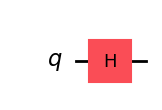

In [4]:
equal_superposition = qiskit.QuantumCircuit(1)
equal_superposition.h(0)
equal_superposition.draw("mpl")

We also have to specify the target in which we want to prepare the states. These two pieces of information are what make up a state to be passed to `submit_dfe`, which is a tuple with the circuit that prepares the state as its first element and the target as its second element.

In [5]:
target = "ss_unconstrained_simulator"
rho = (equal_superposition, target)

With this, we can run the protocol comparing the state we defined to itself.

In [6]:
ids = provider.submit_dfe(
    rho_1=rho,
    rho_2=rho,
    num_random_bases=50,
    shots=1000,
)
result = provider.process_dfe(ids)

In [7]:
print(result)

0.9994410259335388


As we can see above, we get a fidelity very close to 1, as expected for identical states.

### Orthogonal states

To test our protocol is giving sensible results, we can run it on orthogonal states.

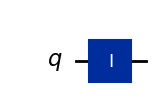

In [9]:
state_1 = qiskit.QuantumCircuit(1)
state_1.id(0)
state_1.draw("mpl")  # |0>

In [10]:
rho_1 = (state_1, target)

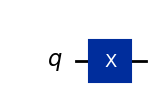

In [11]:
state_2 = qiskit.QuantumCircuit(1)
state_2.x(0)
state_2.draw("mpl")  # |1>

In [12]:
rho_2 = (state_2, target)

To get an idea of how many measurements and shots should be used depending on the number of qubits and any given information about the states, refer to Figure 2 and related text in the paper linked at the beginning of this tutorial.

In [13]:
ids = provider.submit_dfe(
    rho_1=rho_1,
    rho_2=rho_2,
    num_random_bases=50,
    shots=1000,
)
result = provider.process_dfe(ids)

In [14]:
print(result)

0.16255441673134413


We get a fidelity close to 0, expected for orthogonal states.

### A more interesting example

Let's say we want to compare how two different devices prepare two different states. To do this, we can simply set the target for each state to be whatever device we want (as long as you have access to it). We will set `method="dry-run"` for now to simulate the results, but if this argument is removed the circuits will be submitted to the real backend.

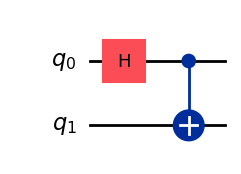

In [15]:
state_1 = qiskit.QuantumCircuit(2)
state_1.h(0)
state_1.cx(0, 1)
state_1.draw("mpl")

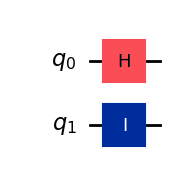

In [16]:
state_2 = qiskit.QuantumCircuit(2)
state_2.h(0)
state_2.id(1)
state_2.draw("mpl")

In [19]:
rho_1 = (state_1, "ibmq_brisbane_qpu")
rho_2 = (state_2, "ibmq_kyiv_qpu")

In [20]:
ids = provider.submit_dfe(
    rho_1=rho_1,
    rho_2=rho_2,
    num_random_bases=50,
    shots=5000,
    method="dry-run",  # Remove this argument to run on real devices
)
result = provider.process_dfe(ids)

In [ ]:
print(result)

0.25785476714708405


We can see how our estimation compares to the ideal value by using the formula for fidelity between pure states.

In [ ]:
np.trace(
    qiskit.quantum_info.DensityMatrix(state_1).data
    @ qiskit.quantum_info.DensityMatrix(state_2).data
)

(0.2499999999999999+0j)